$\textbf{GOAL}$ Continuation of ``l_qut_1`` staying on **linear model** but with a non convex penalty, **$P_\nu$**.

Under sparse hypothesis, we want minimize with $\ell_0$ *(not a norm !)* penalty (the cardinal of the support) but it's discrete optimization and it's very hard. So on the first notebook, we see a relaxation $\ell_1$ with good property (convexity, sparsity, $\dots$). Nonetheless, it has some limits and we better results, so we choose a penalty, $P_\nu$, ""closer"" to $\ell_0$.

# Theory

## Penalty $Rational_\nu$

We consider a class of functions, named by *me* $Rational_\nu$ $\{P_\nu\}_{\nu \in ]0,1[}$ QUT-compatible to the loss function used (SR-LASSO in this notebook).  

We will show later the proof of this compatibility, i.e. $\lambda_0^{local}$ associated is not constant for a design matrix $X$ and random vector $Y$.

For $\nu \in ]0,1]$,

$$P_\nu : \theta \in \mathbb{R}^p \mapsto \sum_{i=1}^p \rho_\nu(\theta_i) \quad \text{with} \quad \rho_\nu : x \in \mathbb{R} \mapsto \frac{|x|}{1+|x|^{1-\nu}} $$

$Rational_\nu$ is continuous, differentiable except in 0, non-convex, locally lipschitz. Moreover, $\rho_\nu$ is even and ``for $ν=0$ it tends to the $ℓ_0$ discrete penalty for |θ| large``.

Then, with $\nu=1$, we get $\ell_1$ penalty as already done in ``l_qut_1`` notebook

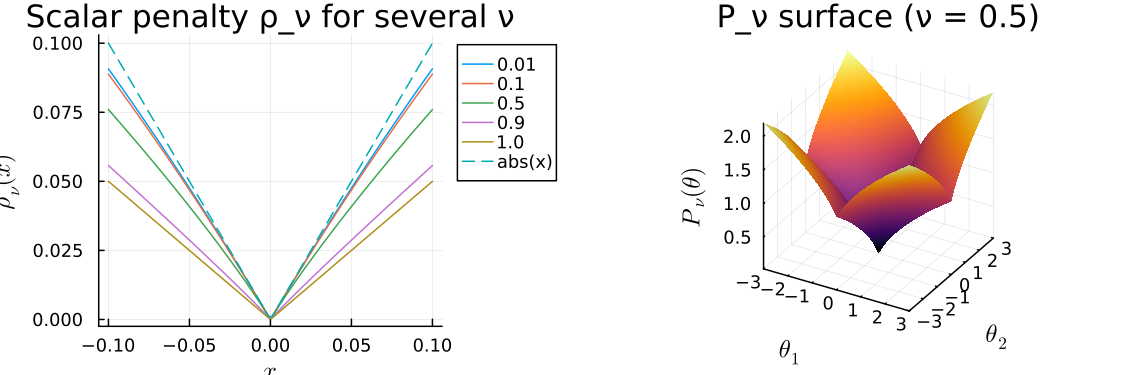

In [4]:
using Plots, LaTeXStrings, Printf
gr()

rho(ν, x) = abs(x) / (1 + abs(x)^(1 - ν))
Pν(ν, θ1, θ2) = rho(ν, θ1) + rho(ν, θ2)

xs  = range(-0.1, 0.1; length = 100)
νs  = [0.01, 0.1, 0.5, 0.9, 1.0]

plt2d = plot(; xlabel = L"x",ylabel = L"\rho_\nu(x)",title  = "Scalar penalty ρ_ν for several ν",legend = :outertopright, neatlegendtitle = L"\nu",legendfontsize = 8,dpi = 150)

for ν in νs
    plot!(plt2d, xs, x -> rho(ν, x), label = "$ν")
end
plot!(plt2d, xs, x -> abs(x), label = "abs(x)", linestyle = :dash)

grid = range(-3, 3; length = 200)
ν     = 0.5
Z     = [Pν(ν, θ1, θ2) for θ2 in grid, θ1 in grid]

plt3d = surface(grid, grid, Z;xlabel = L"\theta_1",ylabel = L"\theta_2",zlabel = L"P_\nu(\theta)",title  = "P_ν surface (ν = $ν)",camera = (30, 30),legend = false)

plot(plt2d, plt3d; layout = (1, 2), size = (750, 250))


## Proximal

We will optimize $f+\lambda g$, with $f=RMSE$ and $g=P_\nu$ and even it's not a convex problem we use ISTA. We discuss about this later and we accept for the moment this choice.

In experiment we will take $\nu$ close to 0 and we need to get the proximal for $\nu \in ]0,1[$ because our penalty change from ``l_qut_1`` with an explicit expression ($\nu = 1$) called *soft thresholding*.

Remember we have, for $\gamma>0, \lambda>0$
$$
\emph{prox}_{\gamma, \lambda P_\nu} : z\in \mathbb{R}^p \mapsto \arg\min_{x\in\mathbb R^{p}}\;\Bigl\{\,\lambda P_\nu(x)+\tfrac1{2\gamma}\|x-z\|_2^2\Bigr\}
$$

By separability of the function inside the $\argmin$ and for $z\in \mathbb{R^p}$, $i\in \llbracket 1,p\rrbracket$

$$[\emph{prox}_{\gamma, \lambda P_\nu}(z)]_i = \arg\min_{x\in\mathbb R}\;
\underbrace{\Bigl\{\,\lambda \rho_\nu(x)+\tfrac1{2\gamma}(x-z)^2\Bigr\}}_{m(x;z)} $$

We need to compute this prox which is a real analysis problem and we explain by the proof on how to compute it.  
The following is strongly inspired by **Theorem 2.4**

For a given $z$, $m$ is continuous (as sum of continuous function on $\mathbb{R}) and is coercive. So the global minimum is a local minima so $0 \in \partial_x m(x;z)$  
(<span style="color:red"><b>TODO :</b></span> KKT ?)

$m$ is even so we restrict our analysis on $\mathbb{R}^+$, then $m$ is differentiable on $\mathbb{R}^{+*}$ with
$$m'(x;z) = \lambda \rho_\nu'(x) + \frac{x-z}{\gamma}, \quad \rho_\nu'(x) = \frac{1+\nu x^{1-\nu}}{\left(1+x^{1-\nu}\right)^2} $$

And in $0$ we can still calculate it's ""derivative"". $m$ is not convex so we can't use the sub-differential but we can consider a more general tool **Clarke sub differential** admits for local lipschitz function.
> Subgradients  
S. Boyd, J. Duchi, and L. Vandenberghe
Notes for EE364b, Stanford University, Spring 2014-15

Indeed, $m$ is local lispchitz because $|\rho_\nu'| \leq |\frac{1+x^{1-\nu}}{\left(1+x^{1-\nu}\right)^2}| \leq  1$ so $\rho_\nu$ is 1-Lipschitz. Then, $x \mapsto \frac{x-z}{\gamma}$ is $C^1$ so locally lipschitz and by sum we got the condition required to be locally lipschitz.



We pass all the theory but for stationnary point we have still $0$ in the interval and the subdifferential is given for the interest point $x$ (for simplicity we stay on $\mathbb{R}$) by the limit from the left and the right. In our case,

$$\partial m(0;z) = \lambda \Bigl[\lim_{x\to0^{-}} \rho_\nu'(x;z); \lim_{x\to0^{+}} \rho_\nu'(x;z)\Bigr] + \{ \frac{x-z}{\gamma}\}$$
By parity,
$$\partial m(0;z) = \lambda\Bigl[\pm lim_{x\to 0^+} \rho_\nu'(x) \Bigr]  + \{\frac{x-z}{\gamma}\}$$
and because 
$\lim_{x\to0^{+}}\rho_\nu'(x)=
\begin{cases}
\dfrac12 & \text{si } \nu=1\\
1 & \text{si } 0<\nu<1
\end{cases}
$

$$\partial m(0;z) =
\begin{cases}
\Bigl[\pm \dfrac{\lambda}{2}-\dfrac{z}{\gamma}\Bigr] & \text{if } \nu=1\\[6pt]
\Bigl[\pm \lambda-\dfrac{z}{\gamma}\Bigr] & \text{if } 0<\nu<1
\end{cases}$$

Hence, $$0\in \partial m(0;z) \Longleftrightarrow \begin{cases}
|z|\leq \frac{1}{2}\lambda \gamma
& \text{if } \nu=1\\[6pt]
|z|\leq \lambda \gamma
& \text{if } 0<\nu<1
\end{cases}$$

So we have at most 2 candidates and we need to known which one choose. We remark if $|z|> \lambda \gamma$ then $0$ is no longer a candidate but it will be useless as information because we will find a "narrow exclusion" for $x=0$. 


In the following, we consider $\nu \in ]0,1[$ because $\nu$ is already treated on the other ntoebook and the notation is heavy to read.

Let $H_z$ and we want to see when it's negative or positive.  $$H_z(x) := m(x;z) - m(0;z) = \frac{1}{2\gamma}(x^2-2xz+z^2) + \lambda\rho_\nu(x) - \frac{z^2}{2\gamma}  =  \frac{1}{2\gamma}(x^2-2xz) + \lambda\rho_\nu(x) $$

We have $H_z(0) = 0$ so we have to know how goes $H_z$ (its "direction"). We derive and denote by $G$,
$$H_z'(x) = \frac{1}{\gamma}(x-z) + \lambda \rho_\nu'(x)=:G(x)-\frac{z}{\gamma}$$

So to know how $H_z'$ behaves we need to know how behaves $G$,

$$G'(x) = \frac{1}{\gamma} + \lambda \rho_\nu''(x) = \frac{1}{\gamma} + (1-\nu)\nu \frac{1-x^{1-\nu}}{x^\nu(1+x^{1-\nu})^3} > 0$$

Then $G$ is strictly increasing and $G(0^+)=\lambda$, we got again that if $|z|\leq \lambda\gamma$ then $H_z'(x)\neq 0$ so $H_z>0$, indeed we see $H(\infty) > 0$ and by continuity it stays positive, so $x=0$ is solution.

<!-- We consider hence the case $z>\lambda\gamma$ (and the negative case is symmetric).  
So for this case by strict increasing and continuity (Theorem intermediate value) there exists $\kappa$ such that $$G(\kappa)=\frac{z}{\gamma} \Longleftrightarrow \frac{\kappa}{\gamma} + \lambda\frac{1+\nu\kappa^{1-\nu}}{(1+\kappa^{1-\nu})^2} = \frac{z}{\gamma} \Longleftrightarrow \kappa + \lambda\gamma\frac{1+\nu\kappa^{1-\nu}}{(1+\kappa^{1-\nu})^2} = z$$

That's to say we now have a stationary candidate and then to check whether the solution switches from 0 to $\kappa$, we evaluate directly,
$$
H_z(\kappa) = \frac{1}{2\gamma}(\kappa^2 - 2\kappa z) + \lambda\rho_\nu(\kappa)
$$ -->


So for $z>\lambda \gamma$, there exists an unique $\kappa$ such as $G(\kappa)=z$ (and $H_z'$ is negative for smaller $x$ and positive for greater than $\kappa$). That's to say $\kappa$ is the only minimizer (as a stationnary point) of $m$.

Hence we look $\Psi : z \in ]\lambda \gamma, \infty[ \mapsto H_z(\kappa)$ to see how it behaves (because on $[0,\lambda \gamma]$ we have $\Psi$>0 as already said).  

$\Psi$ is continuous and strictly decreasing  $$\Psi'(z)=\dfrac{\partial H_z}{\partial z}\bigl(\kappa(z)\bigr) = -\frac{\kappa(z)}{\gamma} <0$$

$$\displaystyle\lim_{z\downarrow\gamma\lambda}\Psi(z)>0$$  

$$\displaystyle\lim_{z\to\infty}\Psi(z)=-\infty$$

By the intermediate value theorem there is a unique $\varphi\in]\gamma\lambda,\infty[$ such that $\Psi(\varphi)=0$.
The switch occurs exactly when  
$$
H_\varphi(\kappa)=0
\quad\text{and}\quad
G(\kappa)=\varphi
$$

We have 
$G(\kappa)=\kappa+\gamma\lambda\frac{1+\nu\kappa^{1-\nu}}{(1+\kappa^{1-\nu})^{2}} =\varphi$
and  



$$
\begin{aligned}
0=H_\varphi(\kappa)
   =\frac{\kappa^2-2\kappa\varphi}{2\gamma}
     +\lambda\rho_\nu(\kappa) = -\frac{\kappa^2}{2\gamma}
    -\lambda\kappa\rho_\nu'(\kappa)
    +\lambda\rho_\nu(\kappa).
\end{aligned}
$$

Multiplying by $\displaystyle\frac{2\gamma\,(1+\kappa^{1-\nu})^{2}}{\kappa}$
gives the polynomial  

$$\kappa^{2-\nu}+2\kappa+\kappa^{\nu}+2\gamma\lambda(\nu-1)=0$$

So $$\varphi=\frac{\kappa}{2}
        +\frac{\gamma\lambda}{1+\kappa^{1-\nu}}$$

We got the system stated in the paper and get a better threshold than $\lambda \gamma$ (got precedently).  
 We define $x^\star : z \in [\lambda\gamma,\infty[ \mapsto$ $G^{-1}_{|[\kappa, \infty[}(z)$   
 So the final answer to get the proximal is given by,

$$
\eta_{\gamma,\lambda,\nu}(z)=
\begin{cases}
0 & |z|\le\varphi\\[4pt]
\operatorname{sign}(z)\,x^\star(|z|) & |z|>\varphi
\end{cases}
$$


So how to compute this ?   
We need to compute the value of $\kappa$, a simple "polynomial" function with one root and the value of $x^\star(|z|)$ given by the inverse of $G$, strictly increasing function $\kappa + \gamma\lambda\frac{1+\nu\kappa^{1-\nu}}{(1+\kappa^{1-\nu})^{2}}$ -z.  

## Compute Proximal

We need two scalars for each $(\lambda,\nu)$:

1. **$\kappa$** Root of the polynomial  
   $$
     g(\kappa)=\kappa^{2-\nu}+2\kappa+\kappa^{\nu}+2\lambda(\nu-1)=0,
     \qquad 0<\nu<1,\;\lambda>0,\;\kappa>0
   $$
   $$g'(\kappa)=(2-\nu)\kappa^{1-\nu}+2+\nu\kappa^{\nu-1}>0$$

2. Inverse map for each data point $x$ (when $x>\varphi$)  
   $$h_z(x)\;:=\;x
          \;+\;\gamma\lambda
               \frac{1+\nu x^{1-\nu}}{\bigl(1+x^{1-\nu}\bigr)^{2}}
          \;-\;z,
          \qquad x>0,\;0<\nu<1$$

$$h_z'(x)=1+\gamma\lambda(1-\nu)\nu\;
        \frac{1-x^{1-\nu}}
             {x^{\nu}(1+x^{1-\nu})^{3}}
        >0$$

Then for methods presented below, we need interval where these function have good properties so we will take for,
* $\kappa$ : $a=0$, $b=\dfrac{\lambda(1-\nu)}2$ (because $g(a)<0<g(b)$)  
* $h_z$ : $a=\kappa$ (because $h_z(\kappa)\leq0$), $b=z$ (because $h_z(z)=\gamma\lambda\rho_\nu'(z)>0$)

### Dichotomie

We need a continuous function $f$ on $[a,b]$ with $f(a)f(b)<0$  
Linear convergence, error after $n$ steps is $(b-a)/2^{n}$.


In [3]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # @assert fa < 0 && fb > 0 "Need f(a)<0<f(b)"
    @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

### Newton

We need $f$ differentiable and $f'$ never 0 on an interval containing the root with an initial guess $x_0$ sufficiently close to the solutiopn with a good landscape.   
We have quadratic convergence.

$$
  x_{k+1}=x_k-\frac{f(x_k)}{f'(x_k)}
$$

In [4]:
function newton(f, fp, x0; tol=1e-10, maxiter=100)
    x = x0
    for k in 1:maxiter
        dfx = fp(x)
        @assert dfx != 0 "Derivative vanished"
        xnew = x - f(x)/dfx
        if abs(xnew - x) <= tol
            return xnew, k
        end
        x = xnew
    end
    error("No convergence in $maxiter iterations")
end

newton (generic function with 1 method)

### Test

In [5]:
using Printf

In [6]:
γ  = 1.0
ν  = 0.5
λ  = 0.5

z  = 1.5 * γ * λ
tol = 1e-10

1.0e-10

In [7]:
g(κ)  = κ^(2-ν) + 2κ + κ^ν + 2λ*(ν - 1)
gp(κ) = (2-ν)*κ^(1-ν) + 2 + ν*κ^(ν-1)

aκ, bκ = 0.0, max(1.0, 2λ*(1-ν))
while g(bκ) ≤ 0                 # enlarge until sign change
    bκ *= 2
end
κ_bis, it_bis_g = bisection(g, aκ, bκ; tol = tol)
κ_new, it_new_g = newton(g, gp, (aκ + bκ)/2; tol = tol)

@printf("(bisection) = %.12f  in %d iters\n", κ_bis, it_bis_g)
@printf("(Newton)    = %.12f  in %d iters\n", κ_new, it_new_g)
@assert abs(κ_bis - κ_new) ≤ tol

(bisection) = 0.088301990356  in 34 iters
(Newton)    = 0.088301990352  in 4 iters


In [8]:
f_z(x)  = x + γ*λ*(1 + ν*x^(1-ν))/ (1 + x^(1-ν))^2 - z
fp_z(x) = 1 + γ*λ*(1-ν)*ν * (1 - x^(1-ν)) / (x^ν * (1 + x^(1-ν))^3)

xL, xR = κ_bis, z             # bracket [κ , z]
x_bis, it_bis_f = bisection(f_z, xL, xR; tol = tol)
x_new, it_new_f = newton(f_z, fp_z, z; tol = tol)

@printf("\n(bisection) = %.12f  in %d iters\n", x_bis, it_bis_f)
@printf("(Newton)    = %.12f  in %d iters\n", x_new, it_new_f)
@assert abs(x_bis - x_new) ≤ tol


(bisection) = 0.520399272117  in 29 iters
(Newton)    = 0.520399272136  in 12 iters


## Visualisation

In [9]:
γ = 1.0
ν = 0.5

0.5

In [10]:
lambdas = [0.05, 0.5, 1.0]
κ_max   = maximum(lambdas)*(1-ν)
θ_grid  = 1e-4:0.001:κ_max 

0.0001:0.001:0.4991

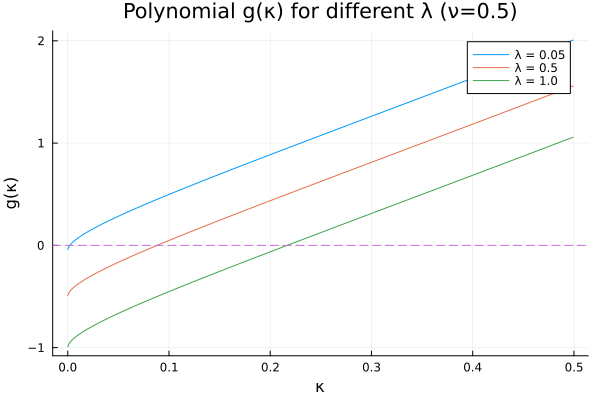

In [11]:
g(κ, λ, ν) = κ^(2-ν) + 2κ + κ^ν + 2λ*(ν-1)

plot(title="Polynomial g(κ) for different λ (ν=$(ν))",xlabel="κ", ylabel="g(κ)",legend=:topright)

for λ in lambdas
    plot!(θ_grid, g.(θ_grid, λ, ν), label="λ = $λ")
end

hline!([0], linestyle=:dash, label="")

In [12]:
soft_threshold(z, λ) = sign(z) * max(abs(z) - λ, 0.0) # nu = 1

function prox_harder_scalar(z, γ, λ, ν)
    Γ = γ*λ
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1)
    κ, _ = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)/2))
    φ = κ/2 + Γ/(1 + κ^(1-ν))
    if abs(z) ≤ φ 
        return 0.0
    else
        h(x) = x + Γ * (1 + ν*x^(1-ν)) / (1 + x^(1-ν))^2 - abs(z)
        xstar, _ = bisection(h, κ, abs(z))
        return sign(z) * xstar
    end
end

prox_harder_scalar (generic function with 1 method)

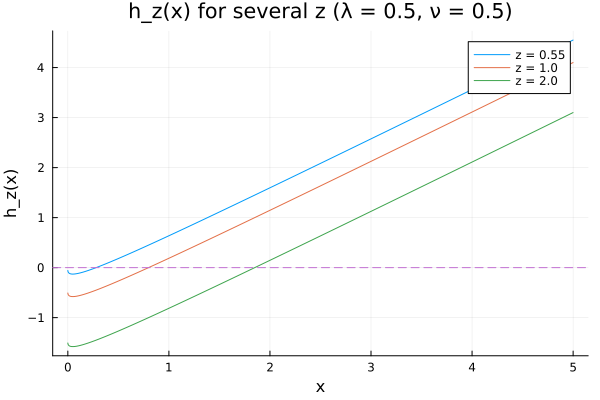

In [13]:
λ  = 0.5   

z_vals = [1.1, 2.0, 4.0] .* γ*λ

x_grid = 1e-4:0.001:5.0

h_z(x, z, γ, λ, ν) = x + γ*λ*(1 + ν*x^(1-ν)) / (1 + x^(1-ν))^2 - z

plot(title = "h_z(x) for several z (λ = $λ, ν = $ν)",
     xlabel = "x", ylabel = "h_z(x)", legend = :topright)

for z in z_vals
    plot!(x_grid, h_z.(x_grid, z, γ, λ, ν),
          label = "z = $(round(z, digits = 3))")
end
hline!([0], linestyle = :dash, label = "")

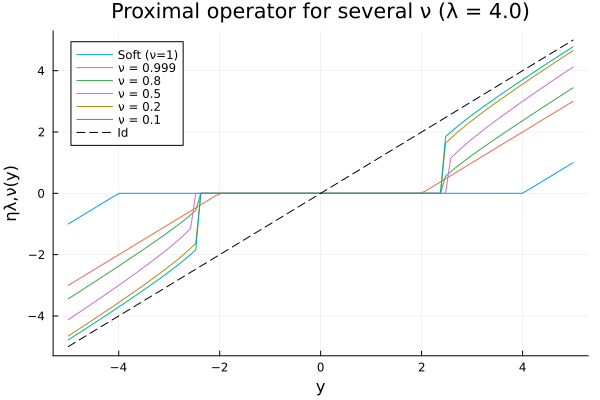

In [14]:
λ = 4.0
γ = 1.0
nus = [1.0, 0.999, 0.8, 0.5, 0.2, 0.1]
z_grid = range(-5, 5; length=100)

plt = plot(title="Proximal operator for several ν (λ = $λ)", xlabel="y", ylabel="ηλ,ν(y)", legend=:topleft)

for ν in nus
    if ν == 1.0
        plot!(plt, z_grid, [soft_threshold(z, λ*γ) for z in z_grid], label="Soft (ν=1)")
    else
        plot!(plt, z_grid, [prox_harder_scalar(z, γ, λ, ν) for z in z_grid], label="ν = $ν")
    end
end

plot!(plt, z_grid, z_grid, linestyle=:dash, color=:black, label="Id") # y=x
display(plt)

<!-- 
To be sure, this is a variational table associated to our analysis,
if $|z|\leq \lambda \gamma$,

|   x                 |   0   |     ]0,+∞[      |   +∞   |
|---------------------|-------|-----------------|--------|
|  $H_z'$    |   +   |        +        |   +    |
| $H_z$    |    0   |       ↗︎        |     +∞   |



 if $|z|> \lambda \gamma$
|  x                       |     0      |   ]0, κ[     |      κ      |  ]κ, +∞[     |  +∞       |
|--------------------------|-----------|--------------|-------------|--------------|-----------|
|  $H_z'$        |    −      |      −       |     0       |      +       |    +      |
|  $H_z$        |     0      |    ↘︎        |         |     ↗︎       |    +$\infty$       |

$$H_z'(0)=\dfrac{0-z}{\gamma}+\lambda\rho\nu'(0)= -\frac{z}{\gamma}+\lambda<0$$
$$\lim_{x\to+\infty}H_z'(x)=\lim_{x\to+\infty} \frac{x}{\gamma}+ o(1) = \infty > 0$$ -->


## QUT-Compatibility

<span style="color:red"><b>TODO :</b></span> Trouver la statistique

# HarderLASSO SR-LASSO

In [15]:
using LinearAlgebra, Statistics, Random, Printf

In [16]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

In [83]:
n = 70 # number of observations
p = 200 # number of variables
s = 5 # sparsity level
ν  = 0.9
σ = 0.1 # oracle noise std
α = 0.05 # desired test level
B_qut = 1000 # simulations for λ_QUT
;

In [84]:
rho(x, ν)  = abs(x) / (1 + abs(x)^(1-ν))
rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [ ]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [86]:
function kappa_phi(Γ::Float64, ν::Float64)kappa_phi
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, _ = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))
    return κ, φ
end

kappa_phi (generic function with 1 method)

In [87]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

x_tar (generic function with 1 method)

In [88]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


prox_harder_vec (generic function with 1 method)

In [89]:
function lambda_local0(y, X; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / norm(r)
end

function lambda_qut_v(X; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_v (generic function with 1 method)

## Landscape

The problem become hard from `l_qut_1` because we no longer have a convex problem, so we fall inside local minima.  
We will try to visualize the effect of changing $\nu$^on the landscape $RMSE  +\lambda P_\nu$

λ = 2.086686549286448


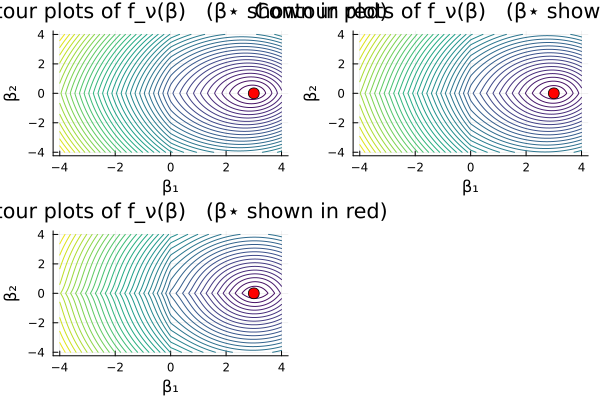

In [74]:
###############################################################################
# harder-LASSO objective landscape for p = 2
# Requires: Julia ≥ 1.6,  Plots.jl (GR backend), LinearAlgebra, Statistics
###############################################################################
using Random, LinearAlgebra, Statistics, Plots
Random.seed!(42)                               # reproducibility & backend

n, p      = 30, 2
X         = randn(n, p)
β_star        = [3.0, 0.0]                               # true coefficients
σ         = 0.5
y         = X*β_star .+ σ*randn(n)                       # response
# λ         = 10.                                      # default penalty
λ = lambda_qut_v(X; α = 0.05, M = 1000, verbose = false) # QUT penalty
print("λ = $λ\n")
νlist     = [1.0, 0.6, 0.001]           # values to explore

# --- penalty helper -----------------------------------------------------------
ρ(x, ν) = abs(x)/(1 + abs(x)^(1-ν))


grid      = range(-4, 4; length = 200)
f(β1, β2, ν) = begin
    # β = SVector(β1, β2)                             # small stack-allocated vec
    β = [β1, β2]                             # small stack-allocated vec
    norm(y - X*β) + λ*sum(ρ.(β, ν))
end

# --- 2-D contour plots --------------------------------------------------------
contours = Plots.Plot[]
for ν in νlist
    fvals = [f(b1, b2, ν) for b2 in grid, b1 in grid]  # note ordering
    push!(contours,
          contour(grid, grid, fvals; levels = 40,
                  c = :viridis, title = "ν = $ν",
                  xlabel = "β₁", ylabel = "β₂", legend = false))
end
foreach(p -> scatter!(p, [β_star[1]], [β_star[2]]; m = (:red, :circle, 6)), contours)

Plots.plot(contours...;  title = "Contour plots of f_ν(β)   (β⋆ shown in red)")


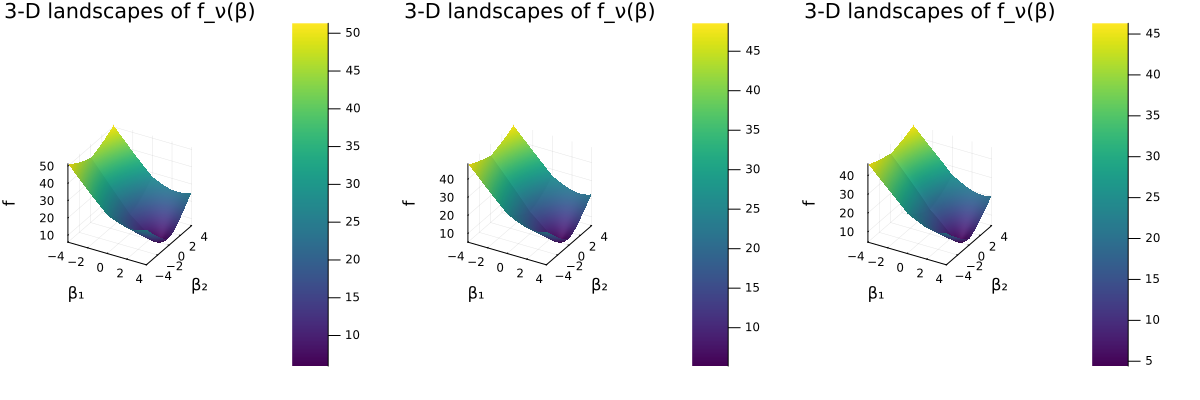

In [219]:

# --- 3-D surface plots --------------------------------------------------------
surface_ν = [1.0, 0.5, 0.001]
surfs = Plots.Plot[]
for ν in surface_ν
    fvals = [f(b1, b2, ν) for b2 in grid, b1 in grid]
    push!(surfs,
          surface(grid, grid, fvals; c = :viridis,
                  xlabel = "β₁", ylabel = "β₂", zlabel = "f",
                  title = "Surface: ν = $ν"))
end

Plots.plot(surfs...; layout = (1, 3), size = (1200, 400),
     title = "3-D landscapes of f_ν(β)")

###############################################################################
# (Optional) If you want λ_QUT instead of a fixed λ, insert its computation
# right after generating X and y, then overwrite λ.
###############################################################################


In [186]:
###############################################################################
# Interactive harder-LASSO surface with ν-slider (GLMakie ≥ v0.21)
###############################################################################
using Random, LinearAlgebra, Statistics
using GLMakie                    # swap for WGLMakie/CairoMakie if you prefer
using StaticArrays               # for SVector
###############################################################################
# Interactive harder-LASSO surface driven by the ν-slider  (GLMakie ≥ 0.21)
###############################################################################
using Random, LinearAlgebra, Statistics
using GLMakie
using StaticArrays

# --- toy data ---------------------------------------------------------------
Random.seed!(42)
n, p  = 100, 2
X     = randn(n, p)
β_star = SVector(3.0, 0.0)
σ, λ   = 0.5, lambda_qut_v(X; α = 0.05, M = 1000, verbose = false)
y      = X*β_star .+ σ*randn(n)

# --- penalty & objective ----------------------------------------------------
ρ(x, ν) = abs(x) / (1 + abs(x)^(1 - ν))
f(β1, β2, ν) = begin
    β = SVector(β1, β2)
    norm(y - X*β) + λ * sum(ρ.(β, ν))
end

# --- grid -------------------------------------------------------------------
grid = range(-4, 4; length = 200)

# --- figure -----------------------------------------------------------------
fig = Figure(size = (800, 600))
ax  = Axis3(fig[1, 1]; xlabel = "β₁", ylabel = "β₂", zlabel = "f")

# slider ─ its `.value` **is already an Observable**
slider = Slider(fig[2, 1]; range = 0.2:0.01:1.0, startvalue = 1.0)
ν = slider.value           # <── just reuse it, no extra Node/connect! needed

# surface that updates when ν changesGLMakie.
GLMakie.surface!(ax, grid, grid,
    @lift([f(b1, b2, $ν) for b2 in grid, b1 in grid]);
    colormap = :viridis)

# true coefficient in red, z-coordinate also tracks ν
GLMakie.scatter!(ax,
    [β_star[2]], [β_star[1]],
    @lift([f(β_star..., $ν)]);
    markersize = 12, color = :red)

fig                               # shows the interactive window
###############################################################################
# Tip: swap `using GLMakie` → `using WGLMakie` for a browser-based widget.
###############################################################################


In [183]:
lambda_qut_v(X; α = 0.05, M = 1000, verbose = false)

2.157066532919593

## Null model verification 

In [100]:
R_null = 10 # number of iterations on differents null models
mu = 1.
c = 0.0 # intercept
false_rejections = 0
tol = 1e-9

Random.seed!(42)

n_print = 1 # print every n_print iterations
c_pred = zeros(R_null) # to store the predictions of the null model

for i in 1:R_null
    # standadization
    X = randn(n, p)
    X .-= mean(X; dims=1)
    X ./= std(X;  dims=1)
    X̃ = hcat(X, ones(n)) # we have intercept (θ₂) so it corresponds to 1

    y = σ*mu* randn(n) .+ c

    λ = lambda_qut_v(X; α=0.05, M=B_qut, rng=Random.GLOBAL_RNG, verbose=false)

    f(θ) = norm(y - X̃*θ,2)
    ∇f(θ) =X̃'*(X̃*θ - y) ./ norm(X̃*θ - y,2)
    penalty(θ) = λ * sum(rho.(θ[1:end-1], ν)) # penalty on β only
    L0 = 0.001
    # θ_warm_start1 = ista(zeros(p+1), f, penalty, ∇f, L0, (z, γ) -> prox_harder_vec(z, γ, 0., 1.); max_iter=100, tol=tol*10^9, verbose=false)
    # θ_warm_start2 = ista(θ_warm_start1, f, penalty, ∇f, L0, (z, γ) -> prox_harder_vec(z, γ, λ/2, 1-ν/2); max_iter=100, tol=tol*10^8, verbose=false)
    θ_hat = ista(zeros(p+1), f, penalty, ∇f, L0, (z, γ) -> prox_harder_vec(z, γ, λ, ν); max_iter=10_000, tol=tol, verbose=false)
    
    c_pred[i] = θ_hat[end] # keep the intercept to see if ISTA works well

    if i % n_print == 0
        @printf("Null model %2d: ‖θ̂₁‖ = %.3e, |θ̂₂| = %.3f\n", i, norm(θ_hat[1:p]), abs(θ_hat[end]))
    end

    if any(abs.(θ_hat[1:p]) .> 0)  # type I check
        false_rejections += 1
    end
end

emp_level = false_rejections / R_null
println("Empirical type-I error ", round(emp_level, digits=3)," (level α = $α)")

Null model  1: ‖θ̂₁‖ = 1.564e-03, |θ̂₂| = 0.010
Null model  2: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.022
Null model  3: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.006
Null model  4: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.015
Null model  5: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.008
Null model  6: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.011
Null model  7: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.011
Null model  8: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.021
Null model  9: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.009
Null model 10: ‖θ̂₁‖ = 0.000e+00, |θ̂₂| = 0.003
Empirical type-I error 0.1 (level α = 0.05)


## Phase transition

In [ ]:
function run_trial_nu(X, β, σ, ν; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0.)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c
    
    λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

    λ_seq = vcat([λ_QUT * exp((k-1)/(1 + exp(k-1))) for k in 0:5],[λ_QUT]) 
    # TODO : pass in argument + same size than lambda_seq
    ν_seq = [1.0, 0.7, 0.4, 0.3, 0.2, 0.1, 0.1]

    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)                             # first warm start

    for (λ, ν) in zip(λ_seq, ν_seq)
        g(θ)      = λ * sum(rho.(θ[1:end-1], ν))  # penalty
        prox( z,γ ) = prox_harder_vec(z, γ, λ, ν)

        θ = ista(θ, f, g, ∇f, L0, prox;max_iter = 10_000,tol= tol,verbose  = false)
    end

    return θ[1:p]       
end

function phase_transition_nu(n, p, s_list, ν; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_nu(X, β, σ, ν; α=α, tol=tol, c=4)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .> 0

            acc_pesr += pesr(β, β_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_nu (generic function with 1 method)

In [102]:
n, p = 70, 250
s_lst = 0:30
B_trial = 50
sigma = 0.1
ν = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_nu(n, p, s_lst, ν; σ=sigma, B=B_trial, tol=1e-9)

(0:30, [1.0, 0.94, 0.94, 0.9, 0.94, 0.94, 0.98, 0.96, 0.92, 0.96  …  0.24, 0.04, 0.02, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.98, 0.988, 0.9857142857142855, 0.9933333333333332, 0.9945454545454544, 0.9984615384615384, 0.9973333333333333, 0.9952941176470589, 0.9978947368421052  …  0.6303651010884457, 0.529747315287414, 0.5187028240997068, 0.42850825145509347, 0.4454737480837003, 0.4096437513592906, 0.40318839440800697, 0.3716739683671127, 0.366070109937049, 0.3672357629478601], [0.0, 0.03, 0.02, 0.025, 0.012000000000000002, 0.01, 0.002857142857142857, 0.005, 0.008888888888888889, 0.004  …  0.2418896871102753, 0.30469911879075295, 0.2907795292942351, 0.4156672937485629, 0.37693064537801385, 0.3944396860449491, 0.4114309320710248, 0.4356388006558287, 0.42889084535362637, 0.4129045890470039], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.5599999999999998, 0.4445454545454544, 0.41652173913043483, 0.34666666666666685, 0.36160000000000003, 0.31923076923076926, 0.311851851851851

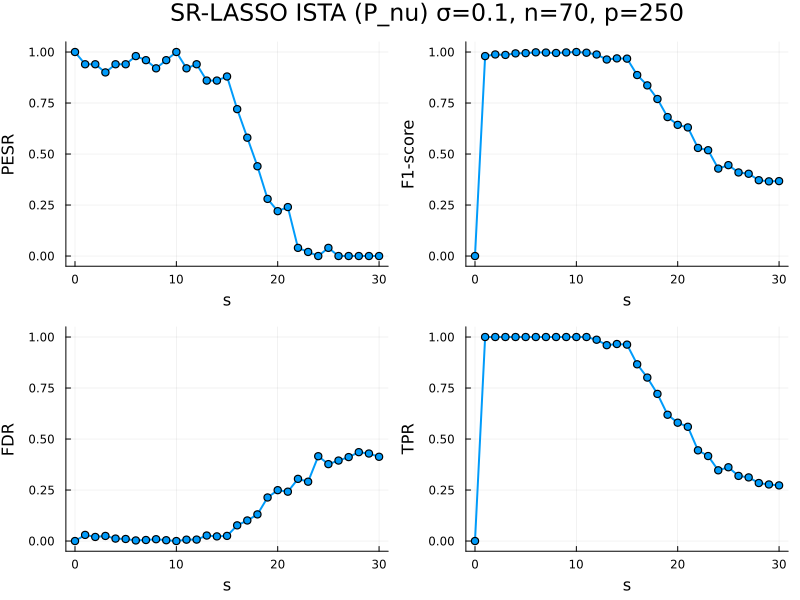

In [103]:
main_title = "SR-LASSO ISTA (P_nu) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

In [106]:
savefig(main_title * ".png")

"c:\\Users\\Le R\\Desktop\\Code\\Projets\\Geneve\\STAGE-GENEVE\\RAPHAEL\\notebook_explain\\SR-LASSO ISTA (P_nu) σ=0.1, n=70, p=250.png"